In [1]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.parameter_fitting.utils import plots
from epymorph.parameter_fitting.utils.observations import Observations
from epymorph.parameter_fitting.utils.ParameterEstimation import EstimateParameters

from epymorph.parameter_fitting.dynamics.dynamics import GeometricBrownianMotion
import scipy
from epymorph.adrio import acs5, csv


In [2]:
from epymorph.data_shape import Shapes
from epymorph.initializer import Initializer
from epymorph.simulation import AttributeDef

import numpy as np


class PFInitializer(Initializer):
    requirements = [AttributeDef("population", int, Shapes.N)]

    def __init__(self, index2=0, index3=0, index4=0) -> None:
        self.index2 = index2
        self.index3 = index3
        self.index4 = index4

    def evaluate(self):
        total_population = self.data("population")[0]  # 7_174_064
        # initial_particle cloud
        initializer = np.array(
            [
                [
                    total_population - self.index2 - self.index3 - self.index4,
                    self.index2,
                    self.index3,
                    self.index4,
                ]
            ],
            dtype=np.int64,
        )
        return initializer

In [3]:
# ruff: noqa: F405
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import Sirh
from epymorph.data.mm.no import No


rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Sirh(),
    # Load an MM from the library
    mm=No(),
    # Use our scope
    scope=StateScope.in_states(["AZ"], year=2015),
    # Create a SingleLocation initializer
    # Provide an initializer of your coice or create a custom initializer as
    # above and pass it
    init=PFInitializer(50, 1434813, 23),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2022-10-01", 371),
    # Provide parameter values
    params={
        # "beta": To be estimated,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.03,
        "hospitalization_duration": 5.0,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
    },
)

In [4]:
[e.name.full for e in rume.ipm.events]

['S → I', 'I → H', 'I → R', 'H → R', 'R → S']

In [5]:
from epymorph.parameter_fitting.utils.resampler import ResamplingByNode


likelihood_fn = PoissonLikelihood()
filter_type = ParticleFilter(num_particles=250, resampler=ResamplingByNode)

In [6]:
from pathlib import Path

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./influenza.csv"),
    time_col=0,
    time_frame=TimeFrame.range("2022-10-01", "2023-09-30"),
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [7]:
# observations = Observations(
#     InfluenzaHospitalizationSumState(rume.time_frame),
#     model_link="I → H",
# )

observations = Observations(
    csvadrio,
    model_link="I → H",
)


In [8]:
params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=scipy.stats.uniform(loc=0.1, scale=0.7),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    )
}

In [9]:
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    likelihood_fn=likelihood_fn,
    filter_type=filter_type,
    params_space=params_space,
)

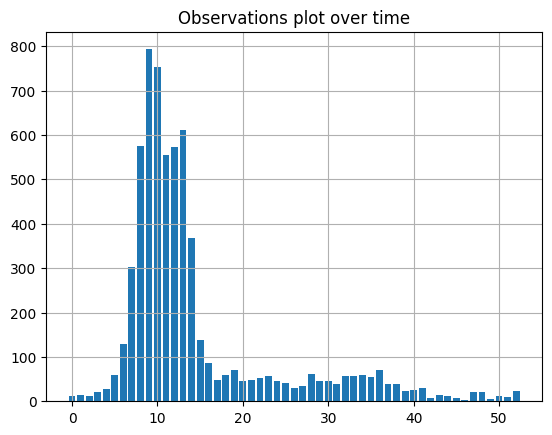

In [10]:
sim.plot_data()

In [11]:
output = sim.run()

100%|██████████| 53/53 [00:48<00:00,  1.09it/s]


In [12]:
output

ParticleFilterOutput(num_particles=250, duration='371 days ', param_quantiles={'beta': [[0.11162673003115156, 0.12089991342867097, 0.13090956353682515, 0.18620580832791747, 0.19936366397589725, 0.21985817877849947, 0.2549044508821202, 0.30178565606046526, 0.34557099942360114, 0.3578184759332921, 0.3888684940035101, 0.4330910993967509, 0.47060643285070936, 0.4863039475804733, 0.5227316567045278, 0.5908476306321057, 0.602623238510213, 0.6513947697530226, 0.6787594436434793, 0.726706691872311, 0.7755835307486375, 0.7824662941370825, 0.7951815535055684], [0.3852770170156183, 0.3852770170156183, 0.3852770170156183, 0.39199171770903546, 0.4501446686631118, 0.5203249139758781, 0.6030802529734488, 0.6030802529734488, 0.6152078776802642, 0.6179571248147516, 0.680912083896688, 0.6994305489730731, 0.772757334941086, 0.8020001232522536, 0.8020001232522536, 0.8020001232522536, 0.8615026726533961, 0.8636685509287256, 0.8958688742742092, 0.9846358577348467, 1.1144157691990413, 1.1144157691990413, 1.1

In [13]:
print(output)

Particle Filter Output
-----------------------
Number of Particles: 250
Duration: 371 days 

Parameter Quantiles (Showcasing a few values):
beta:   0.112, 0.121, 0.131, 0.186, 0.199, 0.220, 0.255, 0.302, 0.346, 0.358, 0.389, 0.433, 0.471, 0.486, 0.523, 0.591, 0.603, 0.651, 0.679, 0.727, 0.776, 0.782, 0.795
  0.385, 0.385, 0.385, 0.392, 0.450, 0.520, 0.603, 0.603, 0.615, 0.618, 0.681, 0.699, 0.773, 0.802, 0.802, 0.802, 0.862, 0.864, 0.896, 0.985, 1.114, 1.114, 1.131

Parameter Values (Showcasing a few values):
beta: 0.439, 0.710, 0.457

True Data:
  10.000
  16.000
  12.000
  17.000
  31.000

Model Data:
  50.000
  3.988
  60.616
  36.468
  32.740


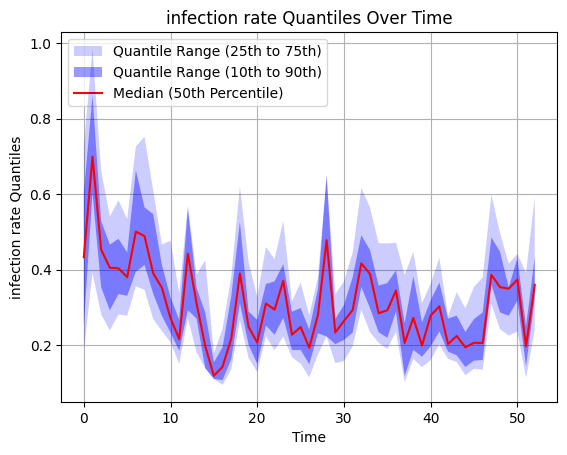

In [14]:
plots.params_plot(output=output, parameter="infection rate")

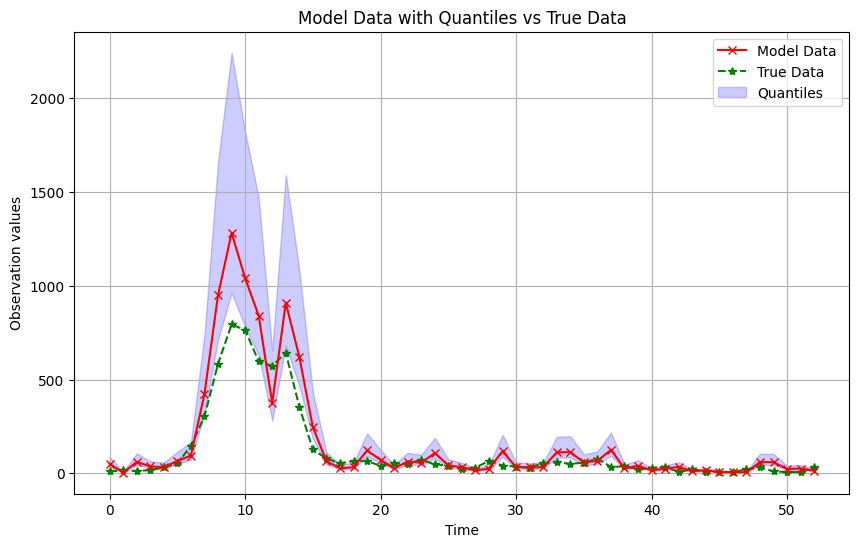

In [15]:
plots.model_fit(output=output)